# Training Neural Networks to predict Scf

## Load Data
### Loading MODIS snow cover dataset

In [1]:
import xarray as xr
import geopandas as gpd
import rioxarray
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
import numpy as np
import pyproj
import pickle
import matplotlib.dates as mdates

In [2]:
import pandas as pd

# Define the path and filename for the dataset
data_file_path = 'Modis/'
data_filename = 'LebanonCSV.csv'

# Load the dataset into a dataframe
snow_cover_data = pd.read_csv(data_file_path + data_filename, index_col=0, decimal='.')

# Convert Day of Year (DOY) indices into datetime format for each year in the dataset
# Each column in the dataframe corresponds to a year, and the index values represent the day of the year
# The datetime conversion results in a matrix of dates corresponding to each year and day combination
date_matrix = pd.DataFrame(
    [pd.to_datetime(snow_cover_data.index - 1, unit='D', origin=str(year)) for year in snow_cover_data.columns]
).transpose()
date_matrix.index = snow_cover_data.index
date_matrix.columns = snow_cover_data.columns

# Convert the matrix structure into a single series by stacking
# This results in a series of dates and a series of snow cover fractions (scf)
dates_series = date_matrix.transpose().stack(dropna=False)
scf_series = snow_cover_data.transpose().stack(dropna=False)

# Combine the dates and scf series into a single dataframe
snow_cover_dataframe = pd.concat([dates_series, scf_series], axis=1, keys=['dates', 'snow_cover_fraction'])
snow_cover_dataframe.dropna(inplace=True)

# Adjust the datetime index to match the Uerra convention, which is 10h
snow_cover_dataframe.index = [date.replace(hour=10) for date in snow_cover_dataframe['dates']]

# Drop the dates column
snow_cover_dataframe.drop('dates', axis=1, inplace=True)

# Remove rows after the date 2022-07-31
cutoff_date = pd.Timestamp(2022, 7, 31, 10)
snow_cover_dataframe = snow_cover_dataframe[snow_cover_dataframe.index <= cutoff_date]


# Display the first 5 elements of the dataset
snow_cover_dataframe.head()

,snow_cover_fraction
2001-01-01 10:00:00,0.106
2001-01-02 10:00:00,0.106
2001-01-03 10:00:00,0.103
2001-01-04 10:00:00,0.096
2001-01-05 10:00:00,0.079


In [3]:
snow_cover_dataframe.tail()

,snow_cover_fraction
2022-07-26 10:00:00,0.0
2022-07-27 10:00:00,0.0
2022-07-28 10:00:00,0.0
2022-07-29 10:00:00,0.0
2022-07-30 10:00:00,0.0


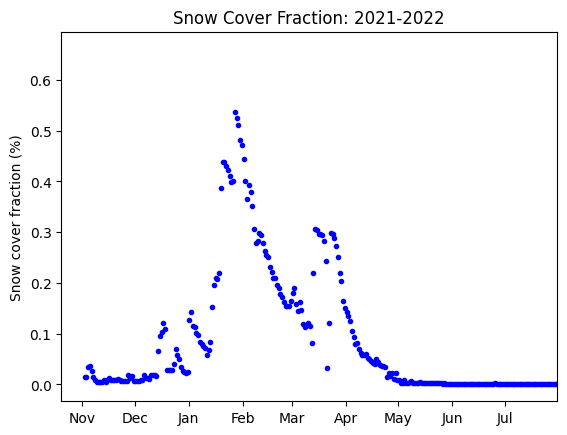

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date

# Extract observation dates and snow cover fractions from the dataframe
observation_dates = snow_cover_dataframe.index
snow_cover_fractions = snow_cover_dataframe['snow_cover_fraction']

# Plot snow cover fractions against observation dates
plt.plot(observation_dates, snow_cover_fractions, marker='.', linestyle='none', color='blue', label='Snow Cover Fraction')

# Set the x-axis limits
start_date = date(2021, 10, 20)
end_date = date(2022, 7, 31)
plt.xlim([start_date, end_date])

# Set the title and y-axis label
plt.title('Snow Cover Fraction: 2021-2022')
plt.ylabel('Snow cover fraction (%)')

# Configure x-axis to show months
current_axis = plt.gca()
current_axis.xaxis.set_major_locator(mdates.MonthLocator())
current_axis.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Display the plot
plt.show()

### Load UERRA snow depth data

Text(0.5, 1.0, 'Mean ERA-5 land snow depth')

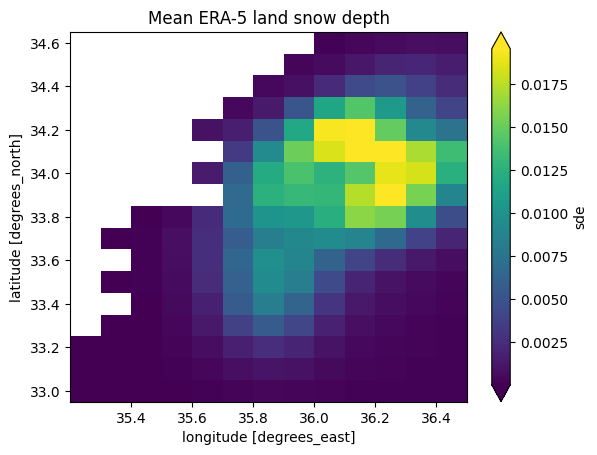

In [5]:
import xarray as xr

# Lazily load all HS netcdf from 2000 onward
snow_depth_dataframe = xr.open_mfdataset('DataExport/Lebanon-Snow-Cover-Data/*.nc')
#cropped_snow_depth_dataframe = snow_depth_dataframe.sel(latitude=slice(33,34.7,),longitude=slice(32,36.7))

# Map mean snow depth of the entire dataset
snow_depth_dataframe.sde.mean(dim='time').plot(robust=True)
plt.title('Mean ERA-5 land snow depth')

<Axes: >

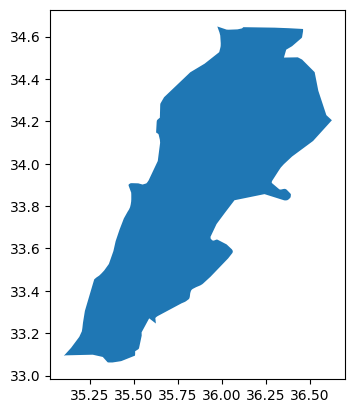

In [6]:
import geopandas as gpd

sf = gpd.read_file('shp/Lebanonshp/LebanonAoi.shp')
sf.plot()

Text(0.5, 1.0, 'Mean ERA5-land snow depth')

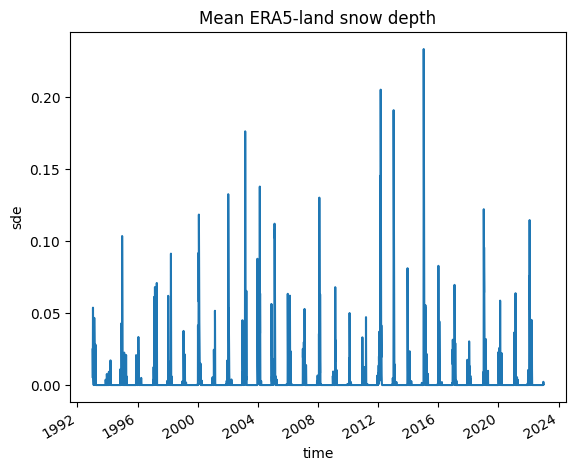

In [7]:
# plot mean snow depth
snow_depth_dataframe.sde.mean(dim=('longitude','latitude')).plot()
plt.title('Mean ERA5-land snow depth')

## Data Preparation
### Combine the two datasets

In [8]:
import numpy as np
# create datesSel vector containing matching dates from both datasets

datesSel = list(set(snow_cover_dataframe.index.values).intersection(snow_depth_dataframe.time.values))
datesSel.sort()
#print("Modis = " ,  Y.index.values)
#print("UERRA =", ds.time.values)
# reduce UERRA dataset to these dates
dsSel = snow_depth_dataframe.sel(time=datesSel)
# Make X array with predictors
X = dsSel['sde'].values.reshape(len(datesSel),-1)
# remove nodata [TODO: APPLY MODIS AOI MASK]
ix = np.all(np.isnan(X),axis=0)
# This is the array of training data (snow depth of every cell)
X = X[:,~ix]
# This is the array of target values (snow cover fraction)
y = snow_cover_dataframe.loc[datesSel].snow_cover_fraction

print('X dimensions:',X.shape)
print('y dimensions:',y.shape)

X dimensions: (5776, 168)
y dimensions: (5776,)


### Define the Nash criteria

In [8]:
def nash(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - numerator / denominator

### Data Exploration

In [9]:
y.head()

2001-01-01 10:00:00    0.106
2001-01-02 10:00:00    0.106
2001-01-03 10:00:00    0.103
2001-01-04 10:00:00    0.096
2001-01-05 10:00:00    0.079
Name: snow_cover_fraction, dtype: float64

In [10]:
y.describe()

count    5776.000000
mean        0.074575
std         0.111974
min         0.000000
25%         0.000000
50%         0.019500
75%         0.114000
max         0.662000
Name: snow_cover_fraction, dtype: float64

In [11]:
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 5776 entries, 2001-01-01 10:00:00 to 2022-07-30 10:00:00
Series name: snow_cover_fraction
Non-Null Count  Dtype  
--------------  -----  
5776 non-null   float64
dtypes: float64(1)
memory usage: 90.2 KB


In [12]:
y.isna().sum()

0

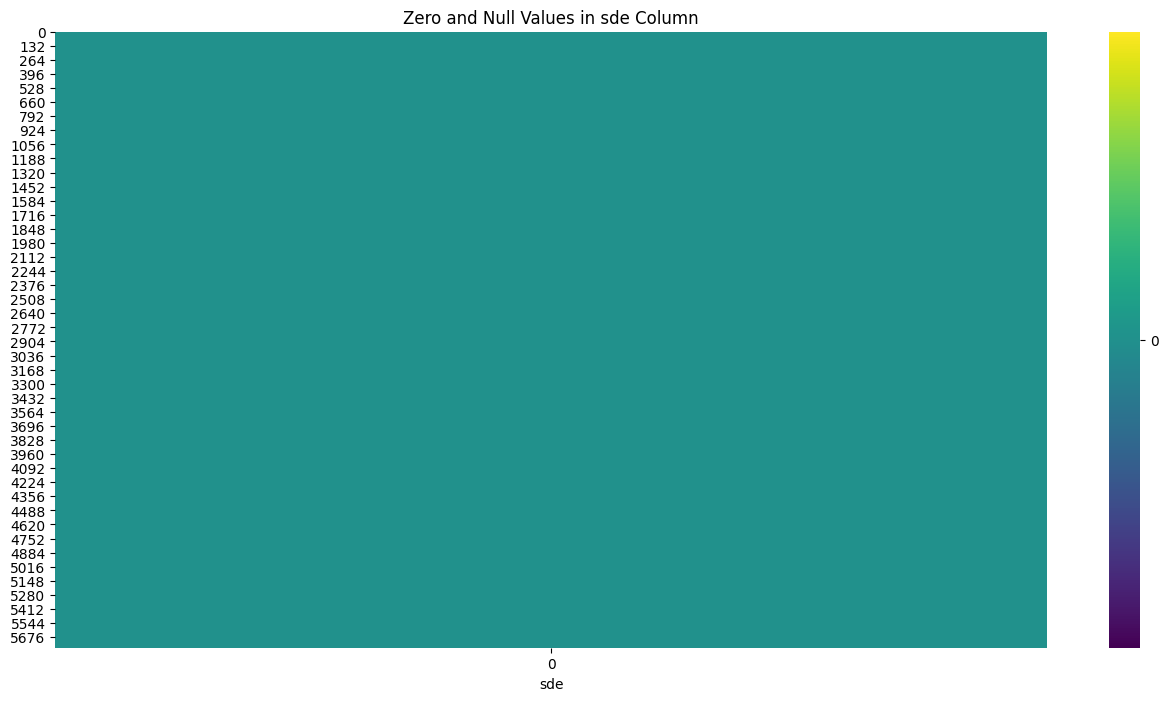

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Series with the same shape as df.sde
combined_sde = pd.Series(index=y.index)

# Mark NaNs with 2
combined_sde[y.isna()] = 2

# Mark zeros with 1
combined_sde[y < 0] = 1

# Fill remaining spots with 0
combined_sde.fillna(0, inplace=True)

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(combined_sde.values.reshape(-1, 1), cbar=True, cmap='viridis', cbar_kws={'ticks': [0, 1, 2]})
plt.title('Zero and Null Values in sde Column')
plt.xlabel('sde')
plt.show()

In [14]:
print("Percentage of below 0 values in the dataset: {}%".format(round(((y.isna().sum() + (y < 0).sum())/y.shape[0])*100, 4)))

Percentage of below 0 values in the dataset: 0.0%


In [15]:
print("Percentage of 0 values in the dataset: {}%".format(round((((y == 0).sum())/y.shape[0])*100, 4)))

Percentage of 0 values in the dataset: 29.0339%


### Data Imputation

In [16]:
from sklearn.ensemble import RandomForestRegressor

def impute_with_rf_and_similar_days(series):
    imputed_series = series.copy()
    rf = RandomForestRegressor(n_estimators=100)
    
    for idx, value in series.items():
        if pd.isnull(value):
            # Extract similar days (same day and month) from other years
            similar_dates = [date for date in series.index if date.month == idx.month and date.day == idx.day and date != idx]
            similar_values = series[similar_dates]
            
            # If there are missing values on similar days, expand the window (e.g., +/- 1 day)
            if similar_values.isna().any():
                expanded_dates = [date for date in series.index if (0 <= (date - idx).days <= 1) and date != idx]
                similar_values = series[expanded_dates]
            
            # Remove any NaNs in the similar values
            valid_similar_values = similar_values.dropna()
            
            # Train the RandomForest using the years of the similar days as features
            X_train = np.array([date.year for date in valid_similar_values.index]).reshape(-1, 1)
            y_train = valid_similar_values.values
            rf.fit(X_train, y_train)
            
            # Predict the missing value using the year of the missing value as the feature
            X_pred = np.array([[idx.year]])
            imputed_value = rf.predict(X_pred)
            
            # Assign the predicted value
            imputed_series[idx] = imputed_value[0]
    
    return imputed_series

In [17]:
y_imputed = impute_with_rf_and_similar_days(y)

### Data Exploration Post Imputation

In [18]:
y_imputed.isna().sum()

0

## Build the predictive models

In [19]:
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dropout, Dense

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def build(self, input_shape):
        # Adjust the output dimension of the final Dense layer in FFN
        self.ffn = Sequential(
            [Dense(self.ff_dim, activation="relu"), Dense(input_shape[-1])]
        )
        super(TransformerBlock, self).build(input_shape)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # First add operation
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Second add operation

2023-11-08 11:41:45.144325: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 11:41:45.162223: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 11:41:45.302669: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 11:41:45.303380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 11:41:45.907990: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import Model

def create_model(model_type='DNN', layers=[50], optimizer='adam', input_shape=(None,), timesteps=1, features=1):
    if model_type == 'DNN':
        model = Sequential(name=model_type)
        for i, nodes in enumerate(layers):
            if i == 0:
                model.add(Dense(nodes, input_shape=input_shape))
            else:
                model.add(Dense(nodes))
            model.add(Activation('relu'))
        model.add(Dense(1))

    elif model_type in ['RNN', 'LSTM', 'GRU']:
        model = Sequential(name=model_type)
        for i, nodes in enumerate(layers):
            if i == 0:
                layer = {'RNN': SimpleRNN, 'LSTM': LSTM, 'GRU': GRU}[model_type]
                model.add(layer(nodes, return_sequences=(i < len(layers) - 1), input_shape=(timesteps, features)))
            else:
                model.add(layer(nodes, return_sequences=(i < len(layers) - 1)))
        model.add(Dense(1))
    
    elif model_type == 'Transformer':
        input_layer = Input(shape=(timesteps, features))
        x = input_layer
        for dim in layers:
            x = TransformerBlock(embed_dim=dim, num_heads=2, ff_dim=dim*4)(x, training=True)
        output_layer = Dense(1)(x)
        model = Model(inputs=input_layer, outputs=output_layer, name=model_type)
    
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    # Define optimizer dynamically
    if optimizer.lower() == 'adam':
        optimizer = Adam()
    elif optimizer.lower() == 'rmsprop':
        optimizer = RMSprop()

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


In [28]:
def forecast(model, X_last, forecasts, model_type='DNN'):
    forecasted_values = []
    for _ in range(forecasts):
        # Different input shapes depending on the model type
        if model_type in ['RNN', 'LSTM', 'GRU']:
            # Reshape X_last to (1, timesteps, features) for RNN, LSTM, GRU
            X_last = X_last.reshape(1, -1, X_last.shape[-1])
        elif model_type == 'Transformer':
            # Reshape X_last to (1, sequence_length, features) for Transformer
            X_last = X_last.reshape(1, X_last.shape[-1])

        prediction = model.predict(X_last)
        forecasted_values.append(prediction[0][0])

        # Update the sequence with the new prediction
        if model_type in ['DNN', 'RNN', 'LSTM', 'GRU']:
            # For RNN-based models, shift the time steps
            X_last = np.roll(X_last, -1)
            X_last[..., -1] = prediction[0][0]  # assuming prediction is shaped as (1, 1)
        elif model_type == 'Transformer':
            # For the Transformer, update the sequence without rolling
            X_last = np.concatenate((X_last[..., 1:], prediction.reshape(1, 1, -1)), axis=-2)

    return forecasted_values


In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_normalized = scaler_X.transform(X)


scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(y_imputed.values.reshape(-1, 1))
y_normalized = scaler_y.transform(y_imputed.values.reshape(-1, 1)).flatten()

In [33]:
# Split data into training and validation sets
train_size = int(0.9 * len(X_normalized))
X_train, X_val = X_normalized[:train_size], X_normalized[train_size:]
y_train, y_val = y_normalized[:train_size], y_normalized[train_size:]  

## Test DNN (Deep Neural Network)

In [62]:
DNN_params = {'batch_size': 16, 
               'epochs': 200, 
               'model__input_shape': (X_normalized.shape[1],), 
               'model__layers': [50, 25, 12], 
               'model__model_type': 'DNN', 
               'model__optimizer': 'Adam',
               'model__timesteps': X_normalized.shape[1],
               'model__features': 1
              }
DNN_model = create_model(
    model_type=DNN_params['model__model_type'],
    layers=DNN_params['model__layers'],
    optimizer=DNN_params['model__optimizer'],
    input_shape=DNN_params['model__input_shape'],
    timesteps=DNN_params['model__timesteps'],     
    features=DNN_params['model__features']
)

# Now compile the model with your chosen loss function and metrics
DNN_model.compile(optimizer=DNN_params['model__optimizer'],
                   loss='mean_squared_error',
                   metrics=['mean_absolute_error'])

DNN_model.summary()

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 50)                8450      
                                                                 
 activation_15 (Activation)  (None, 50)                0         
                                                                 
 dense_35 (Dense)            (None, 25)                1275      
                                                                 
 activation_16 (Activation)  (None, 25)                0         
                                                                 
 dense_36 (Dense)            (None, 12)                312       
                                                                 
 activation_17 (Activation)  (None, 12)                0         
                                                                 
 dense_37 (Dense)            (None, 1)                 13      

In [63]:
history = DNN_model.fit(X_train, y_train, epochs=DNN_params['epochs'], batch_size=DNN_params['batch_size'], validation_data=(X_val, y_val))

Epoch 1/200
325/325 [==============================] - 1s 849us/step - loss: 0.0115 - mean_absolute_error: 0.0748 - val_loss: 0.0074 - val_mean_absolute_error: 0.0662
Epoch 2/200
325/325 [==============================] - 0s 626us/step - loss: 0.0095 - mean_absolute_error: 0.0651 - val_loss: 0.0088 - val_mean_absolute_error: 0.0783
Epoch 3/200
325/325 [==============================] - 0s 630us/step - loss: 0.0088 - mean_absolute_error: 0.0620 - val_loss: 0.0074 - val_mean_absolute_error: 0.0576
Epoch 4/200
325/325 [==============================] - 0s 614us/step - loss: 0.0089 - mean_absolute_error: 0.0616 - val_loss: 0.0075 - val_mean_absolute_error: 0.0721
Epoch 5/200
325/325 [==============================] - 0s 626us/step - loss: 0.0085 - mean_absolute_error: 0.0603 - val_loss: 0.0070 - val_mean_absolute_error: 0.0578
Epoch 6/200
325/325 [==============================] - 0s 619us/step - loss: 0.0083 - mean_absolute_error: 0.0597 - val_loss: 0.0068 - val_mean_absolute_error: 0.057

Epoch 50/200
325/325 [==============================] - 0s 610us/step - loss: 0.0066 - mean_absolute_error: 0.0520 - val_loss: 0.0073 - val_mean_absolute_error: 0.0544
Epoch 51/200
325/325 [==============================] - 0s 628us/step - loss: 0.0065 - mean_absolute_error: 0.0516 - val_loss: 0.0070 - val_mean_absolute_error: 0.0568
Epoch 52/200
325/325 [==============================] - 0s 653us/step - loss: 0.0065 - mean_absolute_error: 0.0519 - val_loss: 0.0076 - val_mean_absolute_error: 0.0604
Epoch 53/200
325/325 [==============================] - 0s 627us/step - loss: 0.0064 - mean_absolute_error: 0.0516 - val_loss: 0.0080 - val_mean_absolute_error: 0.0634
Epoch 54/200
325/325 [==============================] - 0s 601us/step - loss: 0.0065 - mean_absolute_error: 0.0517 - val_loss: 0.0073 - val_mean_absolute_error: 0.0567
Epoch 55/200
325/325 [==============================] - 0s 619us/step - loss: 0.0064 - mean_absolute_error: 0.0514 - val_loss: 0.0069 - val_mean_absolute_error:

Epoch 99/200
325/325 [==============================] - 0s 651us/step - loss: 0.0058 - mean_absolute_error: 0.0488 - val_loss: 0.0078 - val_mean_absolute_error: 0.0594
Epoch 100/200
325/325 [==============================] - 0s 633us/step - loss: 0.0059 - mean_absolute_error: 0.0489 - val_loss: 0.0084 - val_mean_absolute_error: 0.0614
Epoch 101/200
325/325 [==============================] - 0s 657us/step - loss: 0.0059 - mean_absolute_error: 0.0489 - val_loss: 0.0086 - val_mean_absolute_error: 0.0599
Epoch 102/200
325/325 [==============================] - 0s 631us/step - loss: 0.0059 - mean_absolute_error: 0.0490 - val_loss: 0.0084 - val_mean_absolute_error: 0.0582
Epoch 103/200
325/325 [==============================] - 0s 645us/step - loss: 0.0058 - mean_absolute_error: 0.0483 - val_loss: 0.0086 - val_mean_absolute_error: 0.0629
Epoch 104/200
325/325 [==============================] - 0s 640us/step - loss: 0.0059 - mean_absolute_error: 0.0490 - val_loss: 0.0087 - val_mean_absolute_e

325/325 [==============================] - 0s 613us/step - loss: 0.0055 - mean_absolute_error: 0.0468 - val_loss: 0.0085 - val_mean_absolute_error: 0.0665
Epoch 148/200
325/325 [==============================] - 0s 627us/step - loss: 0.0057 - mean_absolute_error: 0.0481 - val_loss: 0.0081 - val_mean_absolute_error: 0.0591
Epoch 149/200
325/325 [==============================] - 0s 655us/step - loss: 0.0055 - mean_absolute_error: 0.0470 - val_loss: 0.0082 - val_mean_absolute_error: 0.0614
Epoch 150/200
325/325 [==============================] - 0s 636us/step - loss: 0.0055 - mean_absolute_error: 0.0471 - val_loss: 0.0080 - val_mean_absolute_error: 0.0610
Epoch 151/200
325/325 [==============================] - 0s 609us/step - loss: 0.0054 - mean_absolute_error: 0.0469 - val_loss: 0.0082 - val_mean_absolute_error: 0.0606
Epoch 152/200
325/325 [==============================] - 0s 616us/step - loss: 0.0054 - mean_absolute_error: 0.0465 - val_loss: 0.0081 - val_mean_absolute_error: 0.0657


325/325 [==============================] - 0s 624us/step - loss: 0.0051 - mean_absolute_error: 0.0451 - val_loss: 0.0078 - val_mean_absolute_error: 0.0609
Epoch 196/200
325/325 [==============================] - 0s 659us/step - loss: 0.0051 - mean_absolute_error: 0.0452 - val_loss: 0.0077 - val_mean_absolute_error: 0.0608
Epoch 197/200
325/325 [==============================] - 0s 635us/step - loss: 0.0051 - mean_absolute_error: 0.0451 - val_loss: 0.0083 - val_mean_absolute_error: 0.0595
Epoch 198/200
325/325 [==============================] - 0s 614us/step - loss: 0.0052 - mean_absolute_error: 0.0456 - val_loss: 0.0080 - val_mean_absolute_error: 0.0573
Epoch 199/200
325/325 [==============================] - 0s 593us/step - loss: 0.0052 - mean_absolute_error: 0.0456 - val_loss: 0.0081 - val_mean_absolute_error: 0.0613
Epoch 200/200
325/325 [==============================] - 0s 607us/step - loss: 0.0051 - mean_absolute_error: 0.0450 - val_loss: 0.0081 - val_mean_absolute_error: 0.0624


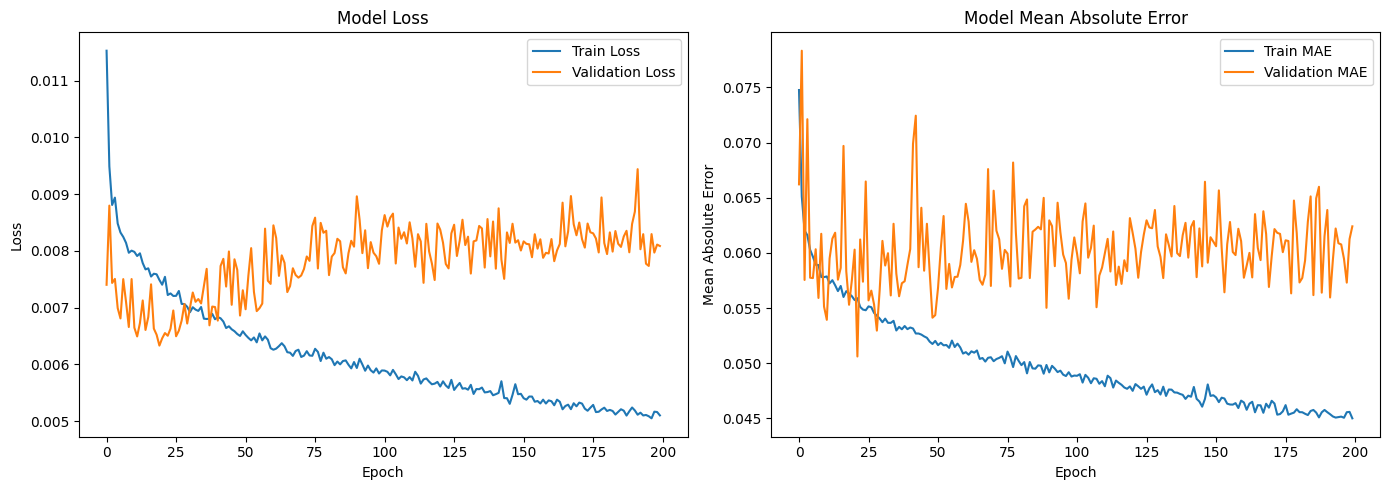

In [64]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot mean absolute error or accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [65]:
# Forecast for the years 2023 to 2032
forecasts = 365 * 10  # 10 years of daily forecasts
X_last = X_normalized[-1].reshape(1, -1)
forecasted_values = forecast(DNN_model, X_last, forecasts)

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


In [66]:
# Inverse transform to get the original scale of the forecasted values
forecasted_values_original_scale = scaler_y.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start="2022-07-30", periods=forecasts, freq="D")
forecast_df = pd.DataFrame({"date": forecast_dates, "scf": forecasted_values_original_scale.flatten()})

# Extend the original dataset with the forecasted values
original_data = pd.DataFrame({"date": y.index, "scf": y.values})
extended_data = pd.concat([original_data, forecast_df], ignore_index=True)

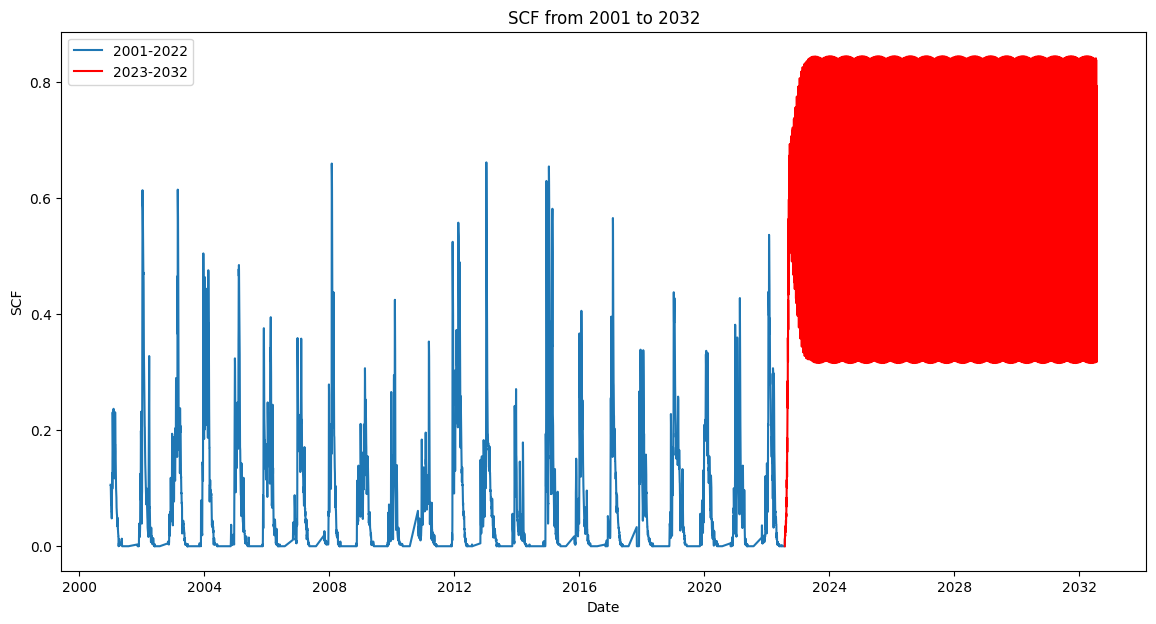

In [88]:
# Convert 'date' to datetime if it's not already
extended_data['date'] = pd.to_datetime(extended_data['date'])

# Set your cutoff date
cutoff_date = pd.to_datetime('2022-07-30')

# Split the data into two periods
data_before_cutoff = extended_data[extended_data['date'] <= cutoff_date]
data_after_cutoff = extended_data[extended_data['date'] > cutoff_date]

# Plotting
plt.figure(figsize=(14, 7))

# Plot the first period
plt.plot(data_before_cutoff['date'], data_before_cutoff['scf'], label='2001-2022')

# Plot the second period
plt.plot(data_after_cutoff['date'], data_after_cutoff['scf'], label='2023-2032', color='red')

plt.xlabel('Date')
plt.ylabel('SCF')
plt.title('SCF from 2001 to 2032')
plt.legend()
plt.show()

##  Test RNN (Recurrent Neural Network)

In [80]:
RNN_params = {'batch_size': 16, 
               'epochs': 25, 
               'model__input_shape': (X_normalized.shape[1],), 
               'model__layers': [50, 25, 12], 
               'model__model_type': 'RNN', 
               'model__optimizer': 'Adamax',
               'model__timesteps': X_normalized.shape[1],
               'model__features': 1
              }
RNN_model = create_model(
    model_type=RNN_params['model__model_type'],
    layers=RNN_params['model__layers'],
    optimizer=RNN_params['model__optimizer'],
    input_shape=RNN_params['model__input_shape'],
    timesteps=RNN_params['model__timesteps'],     
    features=RNN_params['model__features']
)

# Now compile the model with your chosen loss function and metrics
RNN_model.compile(optimizer=RNN_params['model__optimizer'],
                   loss='mean_squared_error',
                   metrics=['mean_absolute_error'])

RNN_model.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_15 (SimpleRNN)   (None, 168, 50)           2600      
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 168, 25)           1900      
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 12)                456       
                                                                 
 dense_43 (Dense)            (None, 1)                 13        
                                                                 
Total params: 4969 (19.41 KB)
Trainable params: 4969 (19.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
history = RNN_model.fit(X_train, y_train, epochs=RNN_params['epochs'], batch_size=RNN_params['batch_size'], validation_data=(X_val, y_val))

Epoch 1/25
325/325 [==============================] - 11s 30ms/step - loss: 0.0124 - mean_absolute_error: 0.0758 - val_loss: 0.0090 - val_mean_absolute_error: 0.0591
Epoch 2/25
325/325 [==============================] - 10s 30ms/step - loss: 0.0105 - mean_absolute_error: 0.0689 - val_loss: 0.0107 - val_mean_absolute_error: 0.0872
Epoch 3/25
325/325 [==============================] - 10s 30ms/step - loss: 0.0102 - mean_absolute_error: 0.0688 - val_loss: 0.0089 - val_mean_absolute_error: 0.0689
Epoch 4/25
325/325 [==============================] - 10s 29ms/step - loss: 0.0107 - mean_absolute_error: 0.0703 - val_loss: 0.0080 - val_mean_absolute_error: 0.0638
Epoch 5/25
325/325 [==============================] - 10s 30ms/step - loss: 0.0101 - mean_absolute_error: 0.0679 - val_loss: 0.0086 - val_mean_absolute_error: 0.0687
Epoch 6/25
325/325 [==============================] - 10s 30ms/step - loss: 0.0098 - mean_absolute_error: 0.0666 - val_loss: 0.0082 - val_mean_absolute_error: 0.0700
Epoc

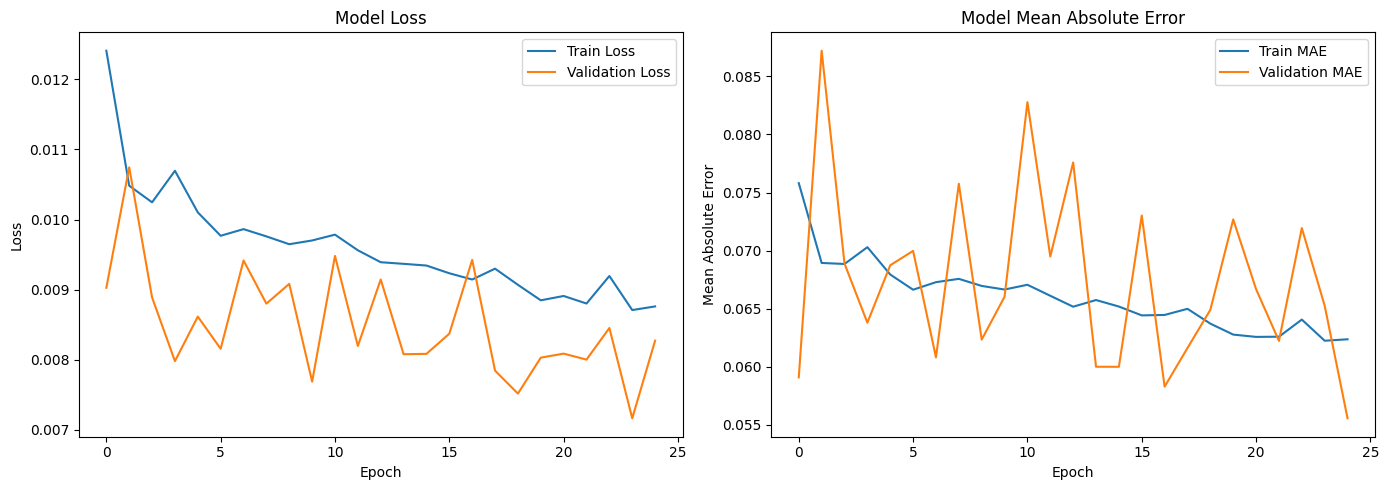

In [82]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot mean absolute error or accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [84]:
# Forecast for the years 2023 to 2032
forecasts = 365 * 10  # 10 years of daily forecasts
X_last = X_normalized[-1].reshape(1, -1)
forecasted_values = forecast(RNN_model, X_last, forecasts)

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


In [85]:
# Inverse transform to get the original scale of the forecasted values
forecasted_values_original_scale = scaler_y.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start="2022-07-30", periods=forecasts, freq="D")
forecast_df = pd.DataFrame({"date": forecast_dates, "scf": forecasted_values_original_scale.flatten()})

# Extend the original dataset with the forecasted values
original_data = pd.DataFrame({"date": y.index, "scf": y.values})
extended_data = pd.concat([original_data, forecast_df], ignore_index=True)

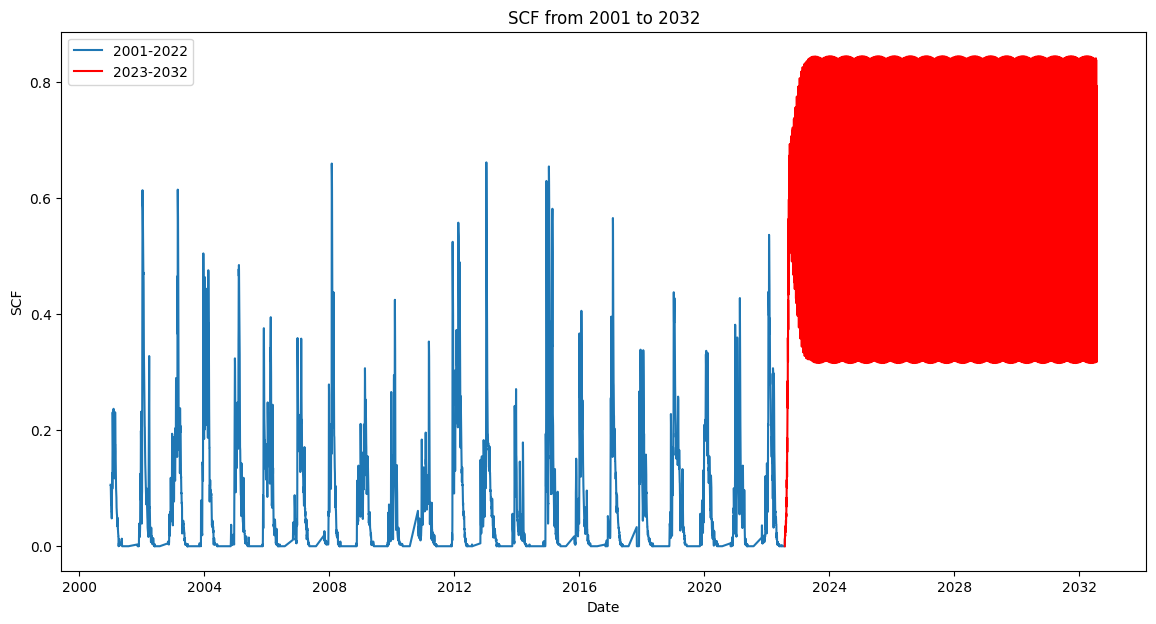

In [89]:
# Convert 'date' to datetime if it's not already
extended_data['date'] = pd.to_datetime(extended_data['date'])

# Set your cutoff date
cutoff_date = pd.to_datetime('2022-07-30')

# Split the data into two periods
data_before_cutoff = extended_data[extended_data['date'] <= cutoff_date]
data_after_cutoff = extended_data[extended_data['date'] > cutoff_date]

# Plotting
plt.figure(figsize=(14, 7))

# Plot the first period
plt.plot(data_before_cutoff['date'], data_before_cutoff['scf'], label='2001-2022')

# Plot the second period
plt.plot(data_after_cutoff['date'], data_after_cutoff['scf'], label='2023-2032', color='red')

plt.xlabel('Date')
plt.ylabel('SCF')
plt.title('SCF from 2001 to 2032')
plt.legend()
plt.show()

## Test LSTM (Long Short-Term Memory)

In [90]:
LSTM_params = {'batch_size': 16, 
               'epochs': 25, 
               'model__input_shape': (X_normalized.shape[1],), 
               'model__layers': [50, 25, 12], 
               'model__model_type': 'LSTM', 
               'model__optimizer': 'Adamax',
               'model__timesteps': X_normalized.shape[1],
               'model__features': 1
              }
LSTM_model = create_model(
    model_type=LSTM_params['model__model_type'],
    layers=LSTM_params['model__layers'],
    optimizer=LSTM_params['model__optimizer'],
    input_shape=LSTM_params['model__input_shape'],
    timesteps=LSTM_params['model__timesteps'],     
    features=LSTM_params['model__features']
)

# Now compile the model with your chosen loss function and metrics
LSTM_model.compile(optimizer=LSTM_params['model__optimizer'],
                   loss='mean_squared_error',
                   metrics=['mean_absolute_error'])

LSTM_model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 168, 25)           7600      
                                                                 
 lstm_2 (LSTM)               (None, 12)                1824      
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 19837 (77.49 KB)
Trainable params: 19837 (77.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
history = LSTM_model.fit(X_train, y_train, epochs=LSTM_params['epochs'], batch_size=LSTM_params['batch_size'], validation_data=(X_val, y_val))

Epoch 1/25
325/325 [==============================] - 21s 58ms/step - loss: 0.0199 - mean_absolute_error: 0.1039 - val_loss: 0.0090 - val_mean_absolute_error: 0.0776
Epoch 2/25
325/325 [==============================] - 19s 57ms/step - loss: 0.0124 - mean_absolute_error: 0.0785 - val_loss: 0.0098 - val_mean_absolute_error: 0.0619
Epoch 3/25
325/325 [==============================] - 19s 57ms/step - loss: 0.0120 - mean_absolute_error: 0.0774 - val_loss: 0.0081 - val_mean_absolute_error: 0.0577
Epoch 4/25
325/325 [==============================] - 19s 58ms/step - loss: 0.0117 - mean_absolute_error: 0.0746 - val_loss: 0.0080 - val_mean_absolute_error: 0.0614
Epoch 5/25
325/325 [==============================] - 19s 58ms/step - loss: 0.0113 - mean_absolute_error: 0.0733 - val_loss: 0.0081 - val_mean_absolute_error: 0.0708
Epoch 6/25
325/325 [==============================] - 19s 58ms/step - loss: 0.0112 - mean_absolute_error: 0.0726 - val_loss: 0.0081 - val_mean_absolute_error: 0.0715
Epoc

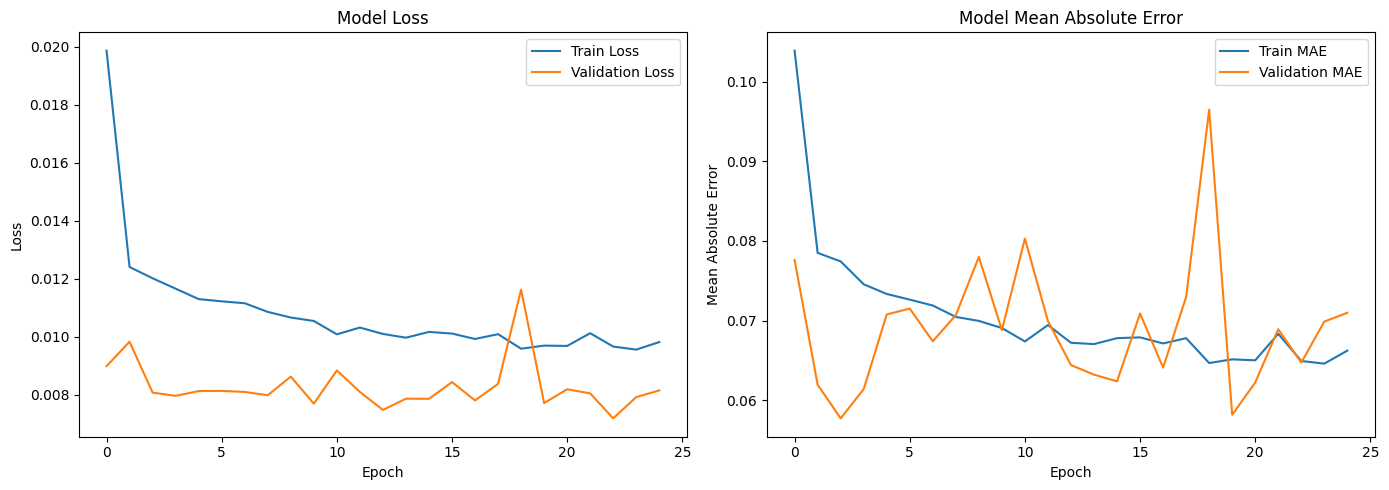

In [92]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot mean absolute error or accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [93]:
# Forecast for the years 2023 to 2032
forecasts = 365 * 10  # 10 years of daily forecasts
X_last = X_normalized[-1].reshape(1, -1)
forecasted_values = forecast(LSTM_model, X_last, forecasts)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


In [94]:
# Inverse transform to get the original scale of the forecasted values
forecasted_values_original_scale = scaler_y.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start="2022-07-30", periods=forecasts, freq="D")
forecast_df = pd.DataFrame({"date": forecast_dates, "scf": forecasted_values_original_scale.flatten()})

# Extend the original dataset with the forecasted values
original_data = pd.DataFrame({"date": y.index, "scf": y.values})
extended_data = pd.concat([original_data, forecast_df], ignore_index=True)

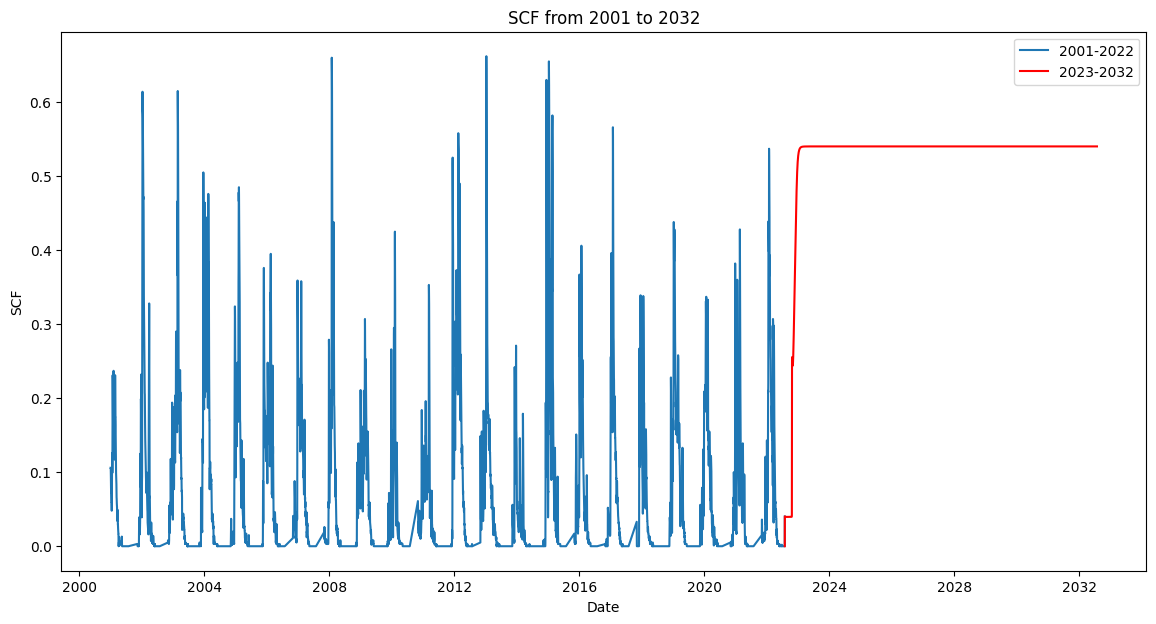

In [95]:
# Convert 'date' to datetime if it's not already
extended_data['date'] = pd.to_datetime(extended_data['date'])

# Set your cutoff date
cutoff_date = pd.to_datetime('2022-07-30')

# Split the data into two periods
data_before_cutoff = extended_data[extended_data['date'] <= cutoff_date]
data_after_cutoff = extended_data[extended_data['date'] > cutoff_date]

# Plotting
plt.figure(figsize=(14, 7))

# Plot the first period
plt.plot(data_before_cutoff['date'], data_before_cutoff['scf'], label='2001-2022')

# Plot the second period
plt.plot(data_after_cutoff['date'], data_after_cutoff['scf'], label='2023-2032', color='red')

plt.xlabel('Date')
plt.ylabel('SCF')
plt.title('SCF from 2001 to 2032')
plt.legend()
plt.show()

## Test GRU (Gated Recurrent Unit)

In [112]:
GRU_params = {'batch_size': 16, 
               'epochs': 25, 
               'model__input_shape': (X_normalized.shape[1],), 
               'model__layers': [50, 25, 12], 
               'model__model_type': 'GRU', 
               'model__optimizer': 'Adamax',
               'model__timesteps': X_normalized.shape[1],
               'model__features': 1
              }
GRU_model = create_model(
    model_type=GRU_params['model__model_type'],
    layers=GRU_params['model__layers'],
    optimizer=GRU_params['model__optimizer'],
    input_shape=GRU_params['model__input_shape'],
    timesteps=GRU_params['model__timesteps'],     
    features=GRU_params['model__features']
)

# Now compile the model with your chosen loss function and metrics
GRU_model.compile(optimizer=GRU_params['model__optimizer'],
                   loss='mean_squared_error',
                   metrics=['mean_absolute_error'])

GRU_model.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 168, 50)           7950      
                                                                 
 gru_4 (GRU)                 (None, 168, 25)           5775      
                                                                 
 gru_5 (GRU)                 (None, 12)                1404      
                                                                 
 dense_59 (Dense)            (None, 1)                 13        
                                                                 
Total params: 15142 (59.15 KB)
Trainable params: 15142 (59.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [113]:
history = GRU_model.fit(X_train, y_train, epochs=GRU_params['epochs'], batch_size=GRU_params['batch_size'], validation_data=(X_val, y_val))

Epoch 1/25
325/325 [==============================] - 23s 63ms/step - loss: 0.0279 - mean_absolute_error: 0.1244 - val_loss: 0.0265 - val_mean_absolute_error: 0.1328
Epoch 2/25
325/325 [==============================] - 20s 61ms/step - loss: 0.0265 - mean_absolute_error: 0.1227 - val_loss: 0.0243 - val_mean_absolute_error: 0.1155
Epoch 3/25
325/325 [==============================] - 20s 63ms/step - loss: 0.0258 - mean_absolute_error: 0.1211 - val_loss: 0.0239 - val_mean_absolute_error: 0.1142
Epoch 4/25
325/325 [==============================] - 20s 63ms/step - loss: 0.0236 - mean_absolute_error: 0.1156 - val_loss: 0.0105 - val_mean_absolute_error: 0.0865
Epoch 5/25
325/325 [==============================] - 22s 68ms/step - loss: 0.0131 - mean_absolute_error: 0.0813 - val_loss: 0.0084 - val_mean_absolute_error: 0.0687
Epoch 6/25
325/325 [==============================] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0765

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


325/325 [==============================] - 22s 67ms/step - loss: 0.0119 - mean_absolute_error: 0.0765 - val_loss: 0.0094 - val_mean_absolute_error: 0.0778
Epoch 7/25
  2/325 [..............................] - ETA: 22s - loss: 0.0077 - mean_absolute_error: 0.0651

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


  6/325 [..............................] - ETA: 23s - loss: 0.0131 - mean_absolute_error: 0.0673

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 10/325 [..............................] - ETA: 23s - loss: 0.0131 - mean_absolute_error: 0.0717

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 14/325 [>.............................] - ETA: 24s - loss: 0.0121 - mean_absolute_error: 0.0720

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 19/325 [>.............................] - ETA: 23s - loss: 0.0108 - mean_absolute_error: 0.0712

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 24/325 [=>............................] - ETA: 22s - loss: 0.0103 - mean_absolute_error: 0.0710

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 28/325 [=>............................] - ETA: 22s - loss: 0.0104 - mean_absolute_error: 0.0701

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 33/325 [==>...........................] - ETA: 22s - loss: 0.0107 - mean_absolute_error: 0.0726

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 37/325 [==>...........................] - ETA: 21s - loss: 0.0113 - mean_absolute_error: 0.0738

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 41/325 [==>...........................] - ETA: 21s - loss: 0.0113 - mean_absolute_error: 0.0739

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 45/325 [===>..........................] - ETA: 21s - loss: 0.0110 - mean_absolute_error: 0.0727

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 50/325 [===>..........................] - ETA: 21s - loss: 0.0118 - mean_absolute_error: 0.0756

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 54/325 [===>..........................] - ETA: 20s - loss: 0.0117 - mean_absolute_error: 0.0768

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 58/325 [====>.........................] - ETA: 20s - loss: 0.0119 - mean_absolute_error: 0.0771

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 62/325 [====>.........................] - ETA: 20s - loss: 0.0122 - mean_absolute_error: 0.0780

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


325/325 [==============================] - 22s 68ms/step - loss: 0.0116 - mean_absolute_error: 0.0752 - val_loss: 0.0084 - val_mean_absolute_error: 0.0708
Epoch 8/25
325/325 [==============================] - 21s 65ms/step - loss: 0.0113 - mean_absolute_error: 0.0732 - val_loss: 0.0090 - val_mean_absolute_error: 0.0804
Epoch 9/25
325/325 [==============================] - 21s 66ms/step - loss: 0.0114 - mean_absolute_error: 0.0732 - val_loss: 0.0083 - val_mean_absolute_error: 0.0688
Epoch 10/25
325/325 [==============================] - 22s 67ms/step - loss: 0.0106 - mean_absolute_error: 0.0702 - val_loss: 0.0092 - val_mean_absolute_error: 0.0612
Epoch 11/25
325/325 [==============================] - 21s 66ms/step - loss: 0.0105 - mean_absolute_error: 0.0702 - val_loss: 0.0075 - val_mean_absolute_error: 0.0603
Epoch 12/25
325/325 [==============================] - 22s 66ms/step - loss: 0.0105 - mean_absolute_error: 0.0698 - val_loss: 0.0080 - val_mean_absolute_error: 0.0666
Epoch 13/25


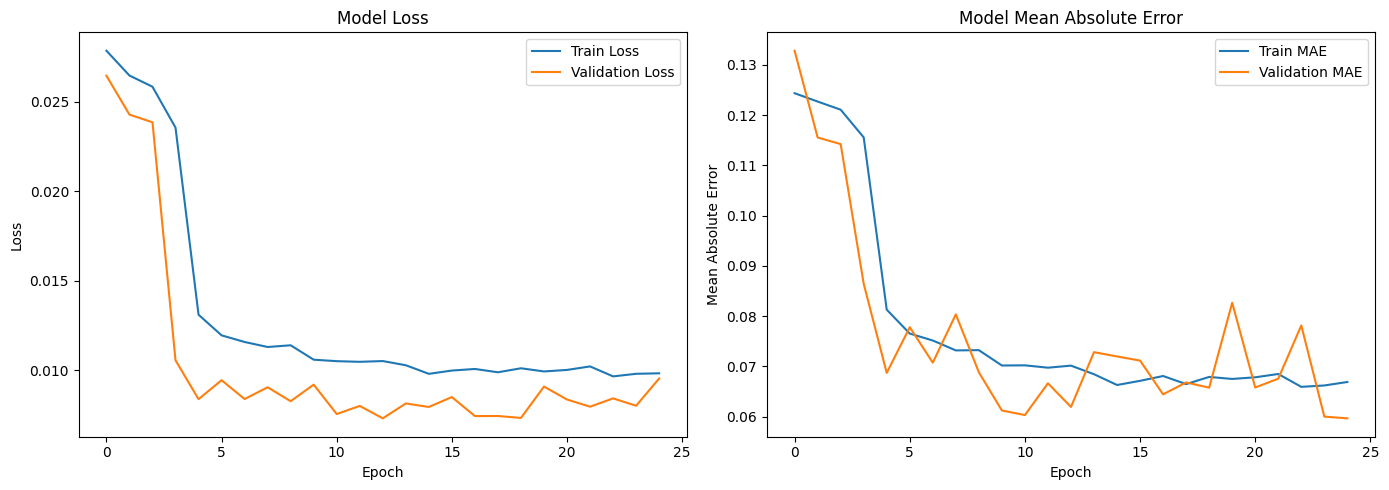

In [114]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot mean absolute error or accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [115]:
# Forecast for the years 2023 to 2032
forecasts = 365 * 10  # 10 years of daily forecasts
X_last = X_normalized[-1].reshape(1, -1)
forecasted_values = forecast(GRU_model, X_last, forecasts)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


In [116]:
# Inverse transform to get the original scale of the forecasted values
forecasted_values_original_scale = scaler_y.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start="2022-07-30", periods=forecasts, freq="D")
forecast_df = pd.DataFrame({"date": forecast_dates, "scf": forecasted_values_original_scale.flatten()})

# Extend the original dataset with the forecasted values
original_data = pd.DataFrame({"date": y.index, "scf": y.values})
extended_data = pd.concat([original_data, forecast_df], ignore_index=True)

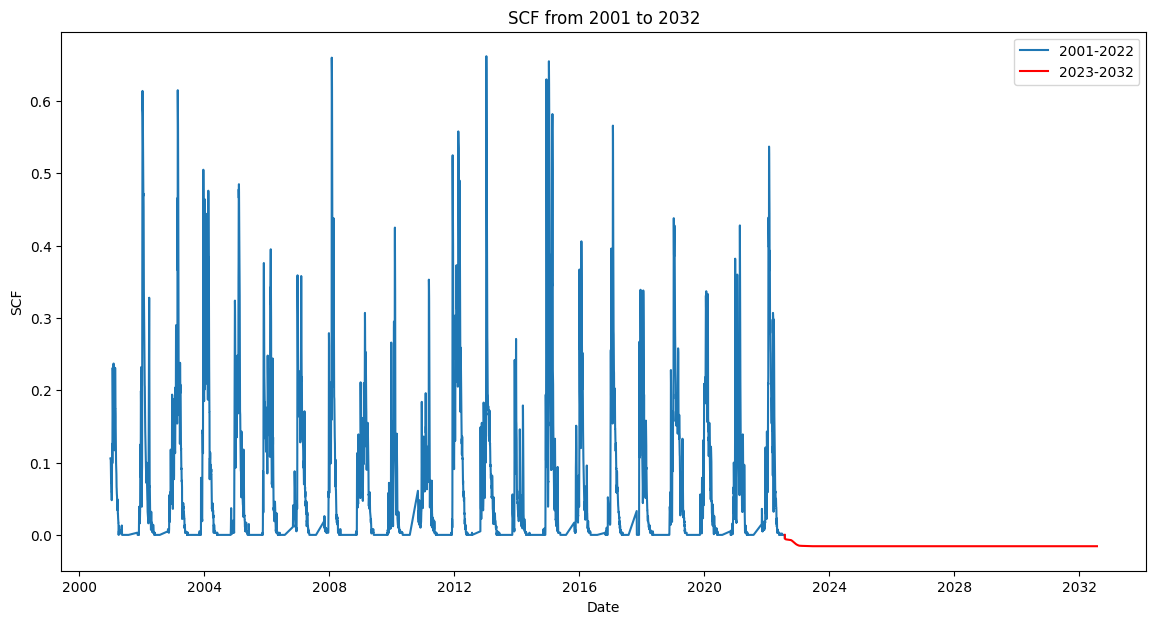

In [117]:
# Convert 'date' to datetime if it's not already
extended_data['date'] = pd.to_datetime(extended_data['date'])

# Set your cutoff date
cutoff_date = pd.to_datetime('2022-07-30')

# Split the data into two periods
data_before_cutoff = extended_data[extended_data['date'] <= cutoff_date]
data_after_cutoff = extended_data[extended_data['date'] > cutoff_date]

# Plotting
plt.figure(figsize=(14, 7))

# Plot the first period
plt.plot(data_before_cutoff['date'], data_before_cutoff['scf'], label='2001-2022')

# Plot the second period
plt.plot(data_after_cutoff['date'], data_after_cutoff['scf'], label='2023-2032', color='red')

plt.xlabel('Date')
plt.ylabel('SCF')
plt.title('SCF from 2001 to 2032')
plt.legend()
plt.show()

## Test Transformer Model

In [97]:
Transformer_params = {'batch_size': 16, 
               'epochs': 25, 
               'model__input_shape': (X_normalized.shape[1],), 
               'model__layers': [50, 25, 12], 
               'model__model_type': 'Transformer', 
               'model__optimizer': 'Adamax',
               'model__timesteps': X_normalized.shape[1],
               'model__features': 1
              }
Transformer_model = create_model(
    model_type=Transformer_params['model__model_type'],
    layers=Transformer_params['model__layers'],
    optimizer=Transformer_params['model__optimizer'],
    input_shape=Transformer_params['model__input_shape'],
    timesteps=Transformer_params['model__timesteps'],     
    features=Transformer_params['model__features']
)

# Now compile the model with your chosen loss function and metrics
Transformer_model.compile(optimizer=Transformer_params['model__optimizer'],
                   loss='mean_squared_error',
                   metrics=['mean_absolute_error'])

Transformer_model.summary()

Model: "Transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 168, 1)]          0         
                                                                 
 transformer_block_6 (Trans  (None, 168, 1)            1306      
 formerBlock)                                                    
                                                                 
 transformer_block_7 (Trans  (None, 168, 1)            656       
 formerBlock)                                                    
                                                                 
 transformer_block_8 (Trans  (None, 168, 1)            318       
 formerBlock)                                                    
                                                                 
 dense_52 (Dense)            (None, 168, 1)            2         
                                                       

In [98]:
history = Transformer_model.fit(X_train, y_train, epochs=Transformer_params['epochs'], batch_size=Transformer_params['batch_size'], validation_data=(X_val, y_val))

Epoch 1/25
325/325 [==============================] - 6s 12ms/step - loss: 0.0305 - mean_absolute_error: 0.1200 - val_loss: 0.0266 - val_mean_absolute_error: 0.1225
Epoch 2/25
325/325 [==============================] - 4s 11ms/step - loss: 0.0289 - mean_absolute_error: 0.1256 - val_loss: 0.0266 - val_mean_absolute_error: 0.1243
Epoch 3/25
325/325 [==============================] - 4s 11ms/step - loss: 0.0288 - mean_absolute_error: 0.1256 - val_loss: 0.0267 - val_mean_absolute_error: 0.1247
Epoch 4/25
325/325 [==============================] - 4s 11ms/step - loss: 0.0289 - mean_absolute_error: 0.1260 - val_loss: 0.0266 - val_mean_absolute_error: 0.1242
Epoch 5/25
325/325 [==============================] - 4s 12ms/step - loss: 0.0288 - mean_absolute_error: 0.1260 - val_loss: 0.0266 - val_mean_absolute_error: 0.1224
Epoch 6/25
325/325 [==============================] - 4s 12ms/step - loss: 0.0288 - mean_absolute_error: 0.1255 - val_loss: 0.0266 - val_mean_absolute_error: 0.1240
Epoch 7/25

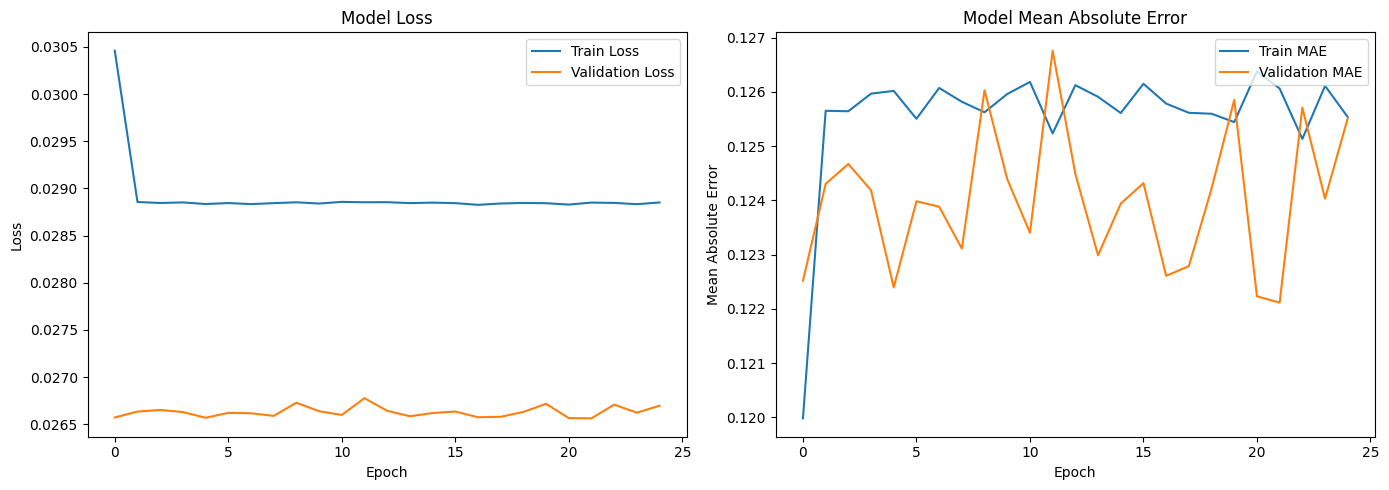

In [99]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot mean absolute error or accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [100]:
# Forecast for the years 2023 to 2032
forecasts = 365 * 10  # 10 years of daily forecasts
X_last = X_normalized[-1].reshape(1, -1)
forecasted_values = forecast(Transformer_model, X_last, forecasts)

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


In [101]:
# Inverse transform to get the original scale of the forecasted values
forecasted_values_original_scale = scaler_y.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start="2022-07-30", periods=forecasts, freq="D")
forecast_df = pd.DataFrame({"date": forecast_dates, "scf": forecasted_values_original_scale.flatten()})

# Extend the original dataset with the forecasted values
original_data = pd.DataFrame({"date": y.index, "scf": y.values})
extended_data = pd.concat([original_data, forecast_df], ignore_index=True)

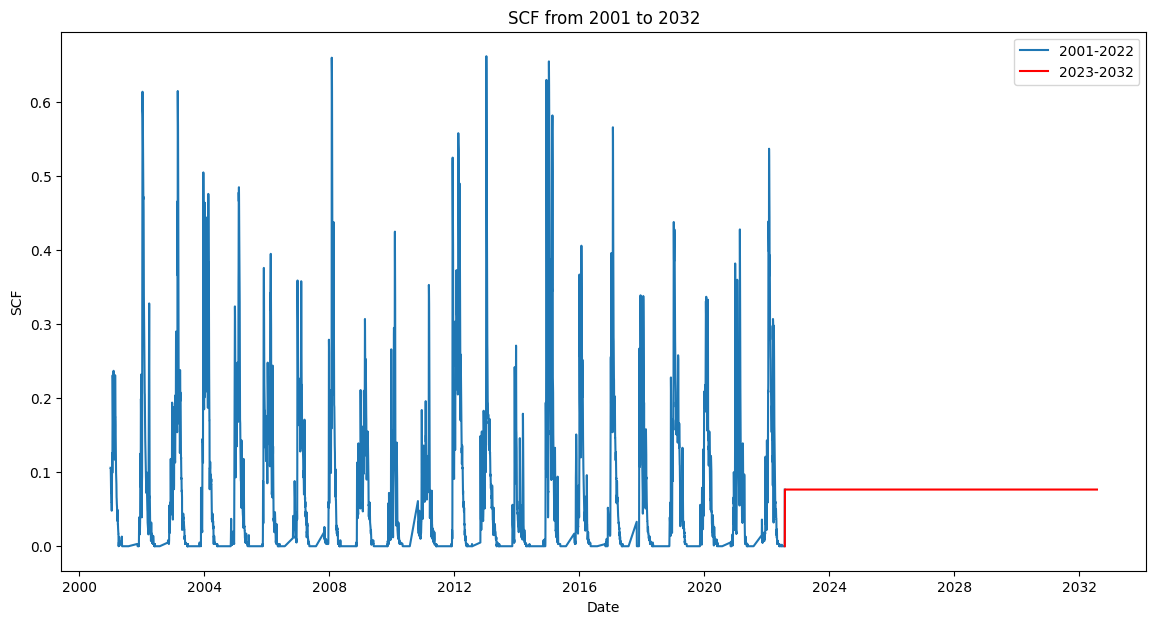

In [102]:
# Convert 'date' to datetime if it's not already
extended_data['date'] = pd.to_datetime(extended_data['date'])

# Set your cutoff date
cutoff_date = pd.to_datetime('2022-07-30')

# Split the data into two periods
data_before_cutoff = extended_data[extended_data['date'] <= cutoff_date]
data_after_cutoff = extended_data[extended_data['date'] > cutoff_date]

# Plotting
plt.figure(figsize=(14, 7))

# Plot the first period
plt.plot(data_before_cutoff['date'], data_before_cutoff['scf'], label='2001-2022')

# Plot the second period
plt.plot(data_after_cutoff['date'], data_after_cutoff['scf'], label='2023-2032', color='red')

plt.xlabel('Date')
plt.ylabel('SCF')
plt.title('SCF from 2001 to 2032')
plt.legend()
plt.show()

#  Combined Approach

In [107]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Set up the grid search
model = KerasRegressor(build_fn=create_model, verbose=2)

layers = [
    [50], [100], [150],
    [50, 25, 12],
]
optimizers = ['Adam', 'RMSprop']
model_types = ['DNN']#, 'RNN', 'LSTM', 'GRU', 'Transformer']

param_grid = {
    'model__layers': layers,
    'model__optimizer': optimizers,
    'model__model_type': model_types,
    'batch_size': [16],
    'epochs': [2],
    'model__input_shape': [(X_normalized.shape[1],)],
    'model__timesteps': [X_normalized.shape[1]],
    'model__features': [1]
}

In [108]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, error_score='raise')
grid_result = grid.fit(X_normalized, y_normalized)

print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

2023-11-08 15:36:14.246678: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 15:36:14.249268: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 15:36:14.259251: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 15:36:14.259267: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABL

2023-11-08 15:36:14.503203: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 15:36:14.505855: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 15:36:14.565354: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 15:36:14.565852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 15:36:14.733794: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You m

2023-11-08 15:36:16.462976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 15:36:16.464224: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-08 15:36:16.535101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2


2023-11-08 15:36:16.729909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 15:36:16.730579: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/2
181/181 - 1s - loss: 0.0142 - mean_absolute_error: 0.0839 - 741ms/epoch - 4ms/step
Epoch 2/2
181/181 - 1s - loss: 0.0163 - mean_absolute_error: 0.0889 - 728ms/epoch - 4ms/step
Epoch 2/2
181/181 - 1s - loss: 0.0133 - mean_absolute_error: 0.0821 - 725ms/epoch - 4ms/step
Epoch 2/2
181/181 - 1s - loss: 0.0168 - mean_absolute_error: 0.0886 - 768ms/epoch - 4ms/step
Epoch 2/2
181/181 - 1s - loss: 0.0127 - mean_absolute_error: 0.0804 - 757ms/epoch - 4ms/step
Epoch 2/2
181/181 - 1s - loss: 0.0166 - mean_absolute_error: 0.0910 - 841ms/epoch - 5ms/step
Epoch 2/2
181/181 - 1s - loss: 0.0178 - mean_absolute_error: 0.0879 - 778ms/epoch - 4ms/step
Epoch 2/2
181/181 - 0s - loss: 0.0114 - mean_absolute_error: 0.0794 - 249ms/epoch - 1ms/step
181/181 - 1s - loss: 0.0131 - mean_absolute_error: 0.0835 - 869ms/epoch - 5ms/step
Epoch 2/2
181/181 - 0s - loss: 0.0137 - mean_absolute_error: 0.0812 - 248ms/epoch - 1ms/step
181/181 - 1s - loss: 0.0142 - mean_absolute_error: 0.0847 - 859ms/epoch - 5ms/st

/home/oem/anaconda3/envs/SnowCoverage/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 0s - loss: 0.0114 - mean_absolute_error: 0.0759 - 440ms/epoch - 1ms/step
Epoch 2/2
361/361 - 0s - loss: 0.0090 - mean_absolute_error: 0.0640 - 150ms/epoch - 414us/step
Best score: 0.616690 using {'batch_size': 16, 'epochs': 2, 'model__features': 1, 'model__input_shape': (168,), 'model__layers': [50, 25, 12], 'model__model_type': 'DNN', 'model__optimizer': 'Adam', 'model__timesteps': 168}


In [ ]:
# Build the best model from grid search
best_params = grid_result.best_params_

best_model = create_model(
    model_type=best_params['model__model_type'],
    layers=best_params['model__layers'],
    optimizer=best_params['model__optimizer'],
    input_shape=best_params['model__input_shape'],
    timesteps=best_params['model__timesteps'],     
    features=best_params['model__features']
)

# Now compile the model with your chosen loss function and metrics
best_model.compile(optimizer=best_params['model__optimizer'],
                   loss='mean_squared_error',
                   metrics=['mean_absolute_error'])

best_model.summary()

In [ ]:
# Train the DNN model
best_model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
# Forecast for the years 2023 to 2032
forecasts = 365 * 10  # 10 years of daily forecasts
X_last = X_normalized[-1].reshape(1, -1)
forecasted_values = forecast(best_model, X_last, forecasts)

In [ ]:
# Inverse transform to get the original scale of the forecasted values
forecasted_values_original_scale = scaler_y.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

In [ ]:
# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start="2022-07-30", periods=forecasts, freq="D")
forecast_df = pd.DataFrame({"date": forecast_dates, "scf": forecasted_values_original_scale.flatten()})

In [ ]:
# Extend the original dataset with the forecasted values
original_data = pd.DataFrame({"date": y.index, "scf": y.values})
extended_data = pd.concat([original_data, forecast_df], ignore_index=True)

In [ ]:
# Save the extended dataset
extended_data.to_csv("extended_dataset_2001_2032.csv", index=False)
print("Forecasting completed and saved to 'extended_dataset_2001_2032.csv'.")

In [ ]:
pwd

In [ ]:
extended_data.head()

In [ ]:
extended_data.tail()

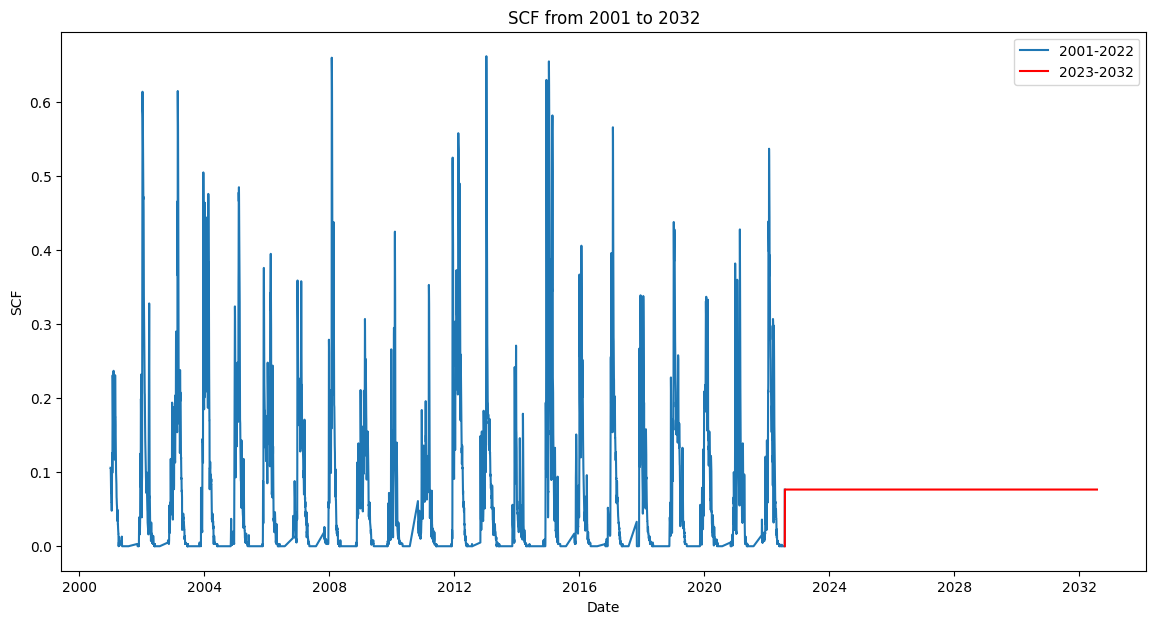

In [105]:
# Convert 'date' to datetime if it's not already
extended_data['date'] = pd.to_datetime(extended_data['date'])

# Set your cutoff date
cutoff_date = pd.to_datetime('2022-07-30')

# Split the data into two periods
data_before_cutoff = extended_data[extended_data['date'] <= cutoff_date]
data_after_cutoff = extended_data[extended_data['date'] > cutoff_date]

# Plotting
plt.figure(figsize=(14, 7))

# Plot the first period
plt.plot(data_before_cutoff['date'], data_before_cutoff['scf'], label='2001-2022')

# Plot the second period
plt.plot(data_after_cutoff['date'], data_after_cutoff['scf'], label='2023-2032', color='red')

plt.xlabel('Date')
plt.ylabel('SCF')
plt.title('SCF from 2001 to 2032')
plt.legend()
plt.show()